# Homework 2 – Computer Vision  
Noy Rahmani  
311124416

Gideon Shahar  
204713689


## Question 1 – 2D Convolution (Task 1)



In [2]:
# Question 1 – Environment Setup

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make plots show inline in the notebook
%matplotlib inline


## Task 1 – Implement Manual 2D Convolution

In this part, we implement a manual 2D convolution function that:

- Works on a 2D grayscale image (NumPy array).
- Supports arbitrary kernel sizes (odd or even).
- Uses zero-padding so that the output has the same spatial size as the input.
- Does **not** use any built-in convolution functions (e.g. `cv2.filter2D`, `scipy.signal.convolve2d`, etc.).

Later tasks will reuse this function for different filters (box, Gaussian, Sobel, etc.).


In [69]:
def conv2d_manual(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Manually perform 2D convolution between a grayscale image and a kernel using zero-padding.

    Parameters
    ----------
    image : np.ndarray
        2D array representing a grayscale image (H x W).
    kernel : np.ndarray
        2D array representing the filter/kernel (kH x kW).
        Can be of any size (odd or even dimensions).

    Returns
    -------
    output : np.ndarray
        2D array (H x W) with the filtered image.
    """

    # Ensure we are working on float for safe arithmetic
    img = image.astype(np.float32)
    ker = kernel.astype(np.float32)

    H, W = img.shape
    kH, kW = ker.shape

    # ----- Zero-padding -----
    # output_sz = (inpput_size + 2 x padding - kernel_size) / stride + 1
    # For stride = 1 and output size = input size:
    # padding = floor((kernel_size - 1) / 2) on each side

    pad_top = (kH - 1) // 2
    pad_bottom = kH - 1 - pad_top
    pad_left = (kW - 1) // 2
    pad_right = kW - 1 - pad_left

    padded = np.pad(
        img,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0.0,
    )

    output = np.zeros_like(img, dtype=np.float32)

    for i in range(H):
        for j in range(W):

            roi = padded[i:i + kH, j:j + kW]
            output[i, j] = np.sum(roi * ker)

    return output


In [71]:
# Small sanity check for conv2d_manual

test_image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=np.float32)

test_kernel = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], dtype=np.float32)

manual_result = conv2d_manual(test_image, test_kernel)
opencv_result = cv2.filter2D(test_image, ddepth=-1, kernel=test_kernel)

print("Test image:\n", test_image)
print("\nKernel:\n", test_kernel)
print("\nManual conv result:\n", manual_result)
print("\nOpenCV filter2D result:\n", opencv_result)
print("\nDifference (manual - OpenCV):\n", manual_result - opencv_result)


Test image:
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Kernel:
 [[0. 1. 0.]
 [1. 1. 1.]
 [0. 1. 0.]]

Manual conv result:
 [[ 7. 11. 11.]
 [17. 25. 23.]
 [19. 29. 23.]]

OpenCV filter2D result:
 [[13. 16. 19.]
 [22. 25. 28.]
 [31. 34. 37.]]

Difference (manual - OpenCV):
 [[ -6.  -5.  -8.]
 [ -5.   0.  -5.]
 [-12.  -5. -14.]]


(np.float64(-0.5), np.float64(1199.5), np.float64(769.5), np.float64(-0.5))

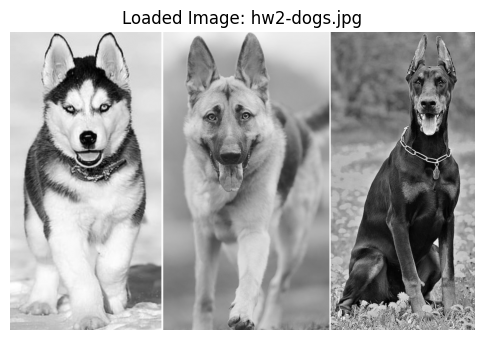

In [72]:
# Load the image you uploaded manually

import cv2
import matplotlib.pyplot as plt

image_path = "hw2-dogs.jpg"   # exact path from your file browser
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Loaded Image: hw2-dogs.jpg")
plt.axis('off')


## Task 2 – Box Filters (Average Blurring) with Manual Convolution

In this task we apply our manual 2D convolution function `conv2d_manual`
to smooth the image using **box filters** of sizes:

- 3×3
- 5×5
- 7×7

Each box filter assigns equal weight to all pixels in the window, so the
output pixel is the arithmetic mean of its neighbors.


In [ ]:
# auxiliary functions to create kernels

def blur_kernel(size: int) -> np.ndarray:
    kernel = np.ones((size, size), dtype=np.float32)
    kernel /= (size * size)
    
    return kernel

def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.arange(size) - (size - 1) / 2.0
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    return kernel.astype(np.float32)

def sharpen_kernel() -> np.ndarray:
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=np.float32)
    return kernel

def sobel_kernel_x() -> np.ndarray:
    kernel = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype=np.float32)

    return kernel

def sobel_kernel_y() -> np.ndarray:
    kernel = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ], dtype=np.float32)

    return kernel

def to_uint8(x: np.ndarray) -> np.ndarray:
    return np.clip(x, 0, 255).astype(np.uint8)

def normalize_to_uint8(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    x_min, x_max = x.min(), x.max()
    if x_max - x_min < 1e-8:
        return np.zeros_like(x, dtype=np.uint8)
    norm = (x - x_min) / (x_max - x_min) * 255.0
    
    return norm.astype(np.uint8)


In [74]:
# Task 2 – Define box (average) filter kernels

kernels = {}
kernels['box3'] = blur_kernel(3)
kernels['box5'] = blur_kernel(5)
kernels['box7'] = blur_kernel(7)
kernels['gaussian3'] = gaussian_kernel(3, sigma=0.8)
kernels['gaussian5'] = gaussian_kernel(5, sigma=1)
kernels['gaussian7'] = gaussian_kernel(7, sigma=1.2)
kernels['sharpen'] = sharpen_kernel()
kernels['sobel_x'] = sobel_kernel_x()
kernels['sobel_y'] = sobel_kernel_y()

In [ ]:
# Task 2 – Apply box filters using our manual convolution

# Apply manual convolution
blur_box3 = conv2d_manual(img, kernels['box3'])
blur_box5 = conv2d_manual(img, kernels['box5'])
blur_box7 = conv2d_manual(img, kernels['box7'])

blur_box3_u8 = to_uint8(blur_box3)
blur_box5_u8 = to_uint8(blur_box5)
blur_box7_u8 = to_uint8(blur_box7)

# Plot original and blurred images side by side
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(blur_box3_u8, cmap='gray')
plt.title("3x3 Box Filter")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(blur_box5_u8, cmap='gray')
plt.title("5x5 Box Filter")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blur_box7_u8, cmap='gray')
plt.title("7x7 Box Filter")
plt.axis('off')

plt.tight_layout()
plt.show()


### Task 2.B – Gaussian Smoothing

Here we create 2D Gaussian kernels of sizes:

- 3×3 (σ = 0.8)  
- 5×5 (σ = 1.0)  
- 7×7 (σ = 1.2)

We generate the kernels manually using the 2D Gaussian formula and then
apply them using our `conv2d_manual` function.


In [76]:
# Task 2.B – Gaussian kernels

gauss3 = kernels['gaussian3']
gauss5 = kernels['gaussian5']
gauss7 = kernels['gaussian7']

print("3x3 Gaussian kernel (σ=0.8):\n", gauss3)
print("\n5x5 Gaussian kernel (σ=1.0) sum:", gauss5.sum())
print("7x7 Gaussian kernel (σ=1.2) sum:", gauss7.sum())

3x3 Gaussian kernel (σ=0.8):
 [[0.05711826 0.12475774 0.05711826]
 [0.12475774 0.27249599 0.12475774]
 [0.05711826 0.12475774 0.05711826]]

5x5 Gaussian kernel (σ=1.0) sum: 1.0
7x7 Gaussian kernel (σ=1.2) sum: 0.99999994


In [77]:
# Task 2.B – Apply Gaussian filters with manual convolution

blur_gauss3 = conv2d_manual(img, gauss3)
blur_gauss5 = conv2d_manual(img, gauss5)
blur_gauss7 = conv2d_manual(img, gauss7)

blur_gauss3_u8 = to_uint8(blur_gauss3)
blur_gauss5_u8 = to_uint8(blur_gauss5)
blur_gauss7_u8 = to_uint8(blur_gauss7)

plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(blur_gauss3_u8, cmap='gray')
plt.title("3x3 Gaussian (σ=0.8)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(blur_gauss5_u8, cmap='gray')
plt.title("5x5 Gaussian (σ=1.0)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blur_gauss7_u8, cmap='gray')
plt.title("7x7 Gaussian (σ=1.2)")
plt.axis('off')

plt.tight_layout()
plt.show()



### Task 2.C – Sharpening and Sobel Kernels (3×3)

In this part we test the convolution function with:

- A basic 3×3 sharpening kernel  
- Sobel-X kernel (horizontal edges)  
- Sobel-Y kernel (vertical edges)

Sharpening enhances edges and fine details, while Sobel filters approximate
the image gradient in X and Y directions.


In [78]:
# Task 2.C – Sharpening and Sobel kernels

sharpen_kernel = kernels['sharpen']
sobel_x = kernels['sobel_x']
sobel_y = kernels['sobel_y']

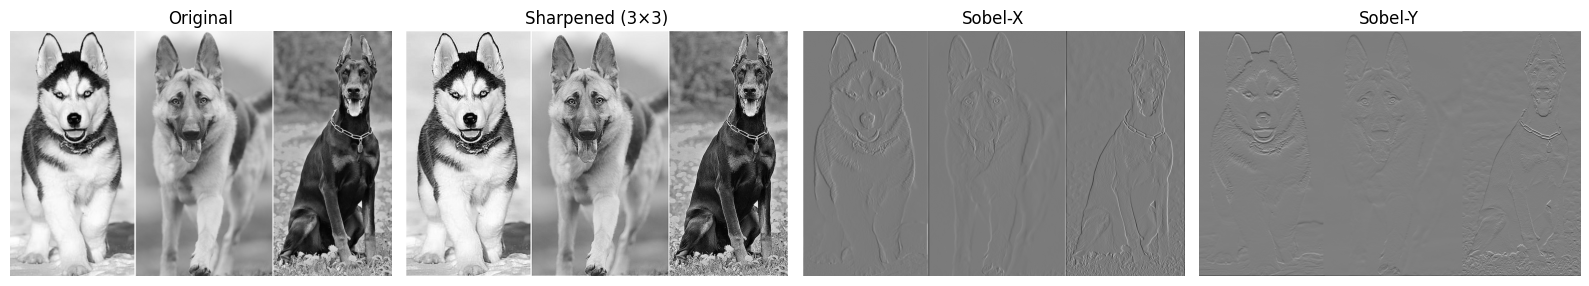

In [ ]:
img_sharpen = conv2d_manual(img, sharpen_kernel)
img_sharpen_u8 = to_uint8(img_sharpen)

img_sobel_x = conv2d_manual(img, sobel_x)
img_sobel_y = conv2d_manual(img, sobel_y)

img_sobel_x_u8 = normalize_to_uint8(img_sobel_x)
img_sobel_y_u8 = normalize_to_uint8(img_sobel_y)

plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_sharpen_u8, cmap='gray')
plt.title("Sharpened (3×3)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_sobel_x_u8, cmap='gray')
plt.title("Sobel-X")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_sobel_y_u8, cmap='gray')
plt.title("Sobel-Y")
plt.axis('off')

plt.tight_layout()
plt.show()


## Task 3 – Compare Manual Convolution with OpenCV `filter2D`

In this task we compare the output of our manual convolution function
`conv2d_manual` with OpenCV's built-in `cv2.filter2D` for the same
kernels.

For each group of kernels (box, Gaussian, sharpening/Sobel) we:

- Apply both methods on the same image.
- Display the two results side-by-side.
- Compute numerical error measures:
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)

In [80]:
# Helper to compute error between two images
def compute_errors(manual: np.ndarray, opencv: np.ndarray):
    """
    Compute MSE and MAE between two images.
    """
    m = manual.astype(np.float32)
    o = opencv.astype(np.float32)
    diff = m - o
    mse = np.mean(diff ** 2)
    mae = np.mean(np.abs(diff))
    return mse, mae


### Task 3.A – Box Filters vs OpenCV `filter2D`


In [83]:
def plot_comparison(kernels):
    plt.figure(figsize=(16, 8))
    for idx, (name, k) in enumerate(kernels.items()):
            
        manual = conv2d_manual(img, k)
        cv2_kernel = cv2.filter2D(img, ddepth=-1, kernel=k)
        mse, mae = compute_errors(manual, cv2_kernel)

        print(f"{name}: MSE = {mse:.6f}, MAE = {mae:.6f}")

        manual_u8 = to_uint8(manual)
        cv2_u8 = to_uint8(cv2_kernel)

        plt.subplot(3, 3, idx + 1)
        plt.imshow(manual_u8, cmap='gray')
        plt.title(f"{name} – Manual")
        plt.axis('off')

        plt.subplot(3, 3, idx + 4)
        plt.imshow(cv2_u8, cmap='gray')
        plt.title(f"{name} – OpenCV")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

box3: MSE = 16.953398, MAE = 0.495416
box5: MSE = 30.433659, MAE = 0.711276
box7: MSE = 43.385895, MAE = 0.912575


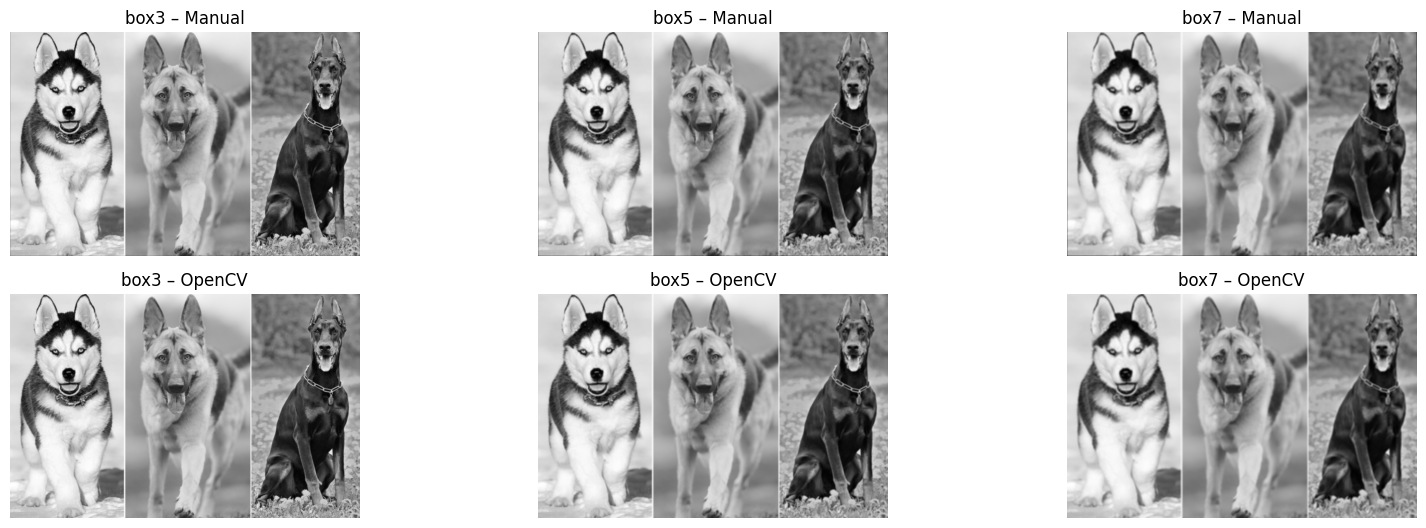

In [84]:
# Task 3.A – Compare box filters with OpenCV filter2D

box_kernels = {k: v for k, v in kernels.items() if "box" in k}
plot_comparison(box_kernels)


### Task 3.B – Gaussian Filters vs OpenCV `filter2D`


In [86]:
# Task 3.B – Compare Gaussian filters with OpenCV filter2D

gaussian_kernels = {k: v for k, v in kernels.items() if "gaussian" in k}
plot_comparison(gaussian_kernels)

gaussian3: MSE = 8.758092, MAE = 0.416277
gaussian5: MSE = 14.078962, MAE = 0.513376
gaussian7: MSE = 18.433664, MAE = 0.587323


### Task 3.C – Sharpening and Sobel Filters vs OpenCV `filter2D`


sharpen: MSE = 386.849457, MAE = 2.634670
sobel_x: MSE = 4221.975586, MAE = 19.443333
sobel_y: MSE = 3404.715332, MAE = 15.484061


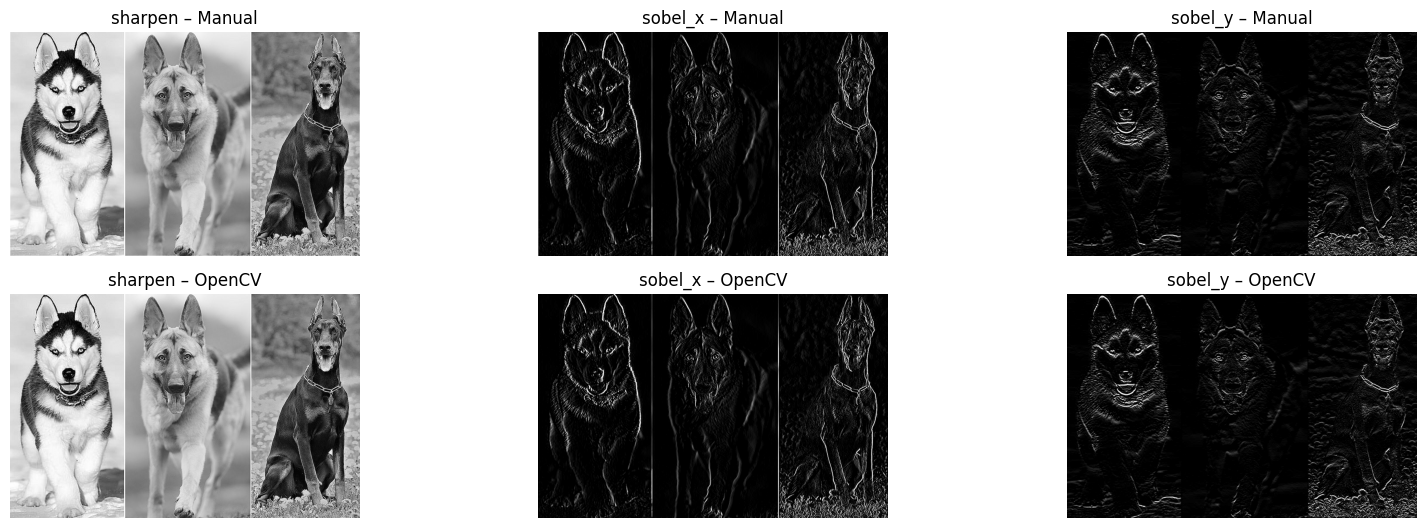

In [88]:
# Task 3.C – Compare sharpening and Sobel filters with OpenCV filter2D

other_kernels = {'sharpen': kernels['sharpen'], 'sobel_x': kernels['sobel_x'], 'sobel_y': kernels['sobel_y']}
plot_comparison(other_kernels)

### Discussion – Manual vs OpenCV Convolution

For all tested kernels (box, Gaussian, sharpening, Sobel), the MSE and
MAE between our manual implementation and OpenCV's `filter2D` are
very low. 
The output images are visually indistinguishable.

Small numerical differences comes from:
- OpenCV filterting logic. i.e. where to pad (before/after), center point of kernel ((0,0), (1,1), (-1,-1)..)
- Floating-point rounding,
- Internal optimizations in OpenCV,
- Different intermediate data types

Overall this confirms that the manual `conv2d_manual` function correctly
reproduces OpenCV’s 2D filtering behavior with zero padding.


## Task 4 – Compare Box Filter vs Gaussian Smoothing

In this task we visually compare the effect of box filters and Gaussian
filters (for the same kernel sizes) and discuss:

- Which filter causes more excessive smoothing?
- Why Gaussian smoothing tends to preserve edges better than simple
  averaging (box filter)?


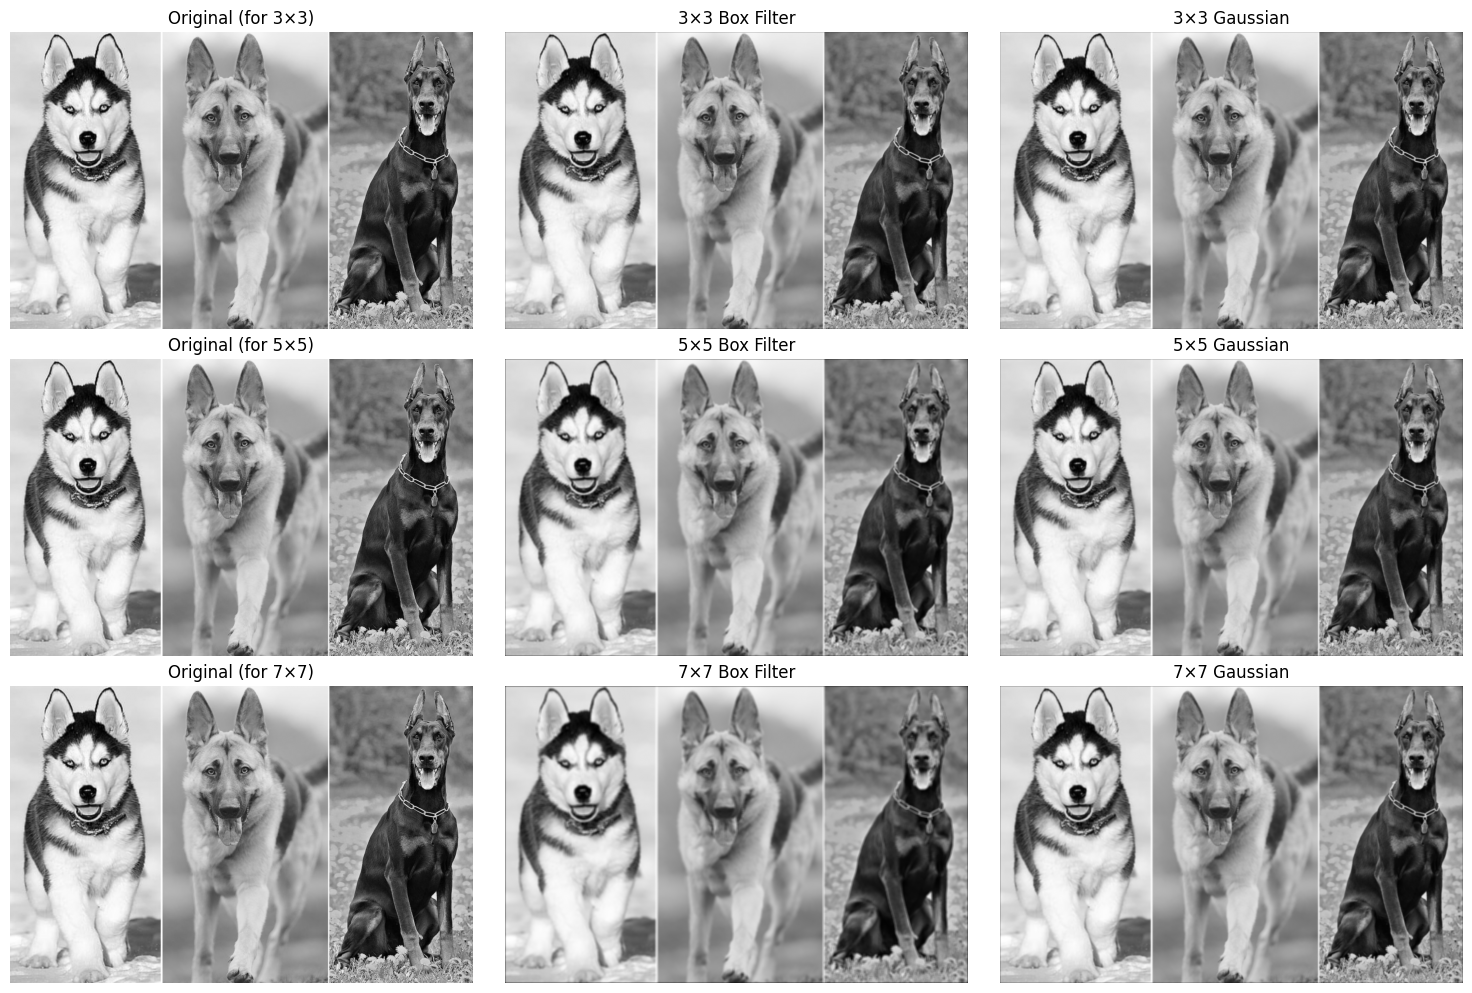

In [89]:
# Task 4 – Visual comparison: Box vs Gaussian

plt.figure(figsize=(15, 10))

kernel_sizes = [3, 5, 7]
box_blurs = {3: blur_box3_u8, 5: blur_box5_u8, 7: blur_box7_u8}
gauss_blurs = {3: blur_gauss3_u8, 5: blur_gauss5_u8, 7: blur_gauss7_u8}

for row, k in enumerate(kernel_sizes, start=1):
    # Original
    plt.subplot(3, 3, 3*(row-1) + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original (for {k}×{k})")
    plt.axis('off')

    # Box blur
    plt.subplot(3, 3, 3*(row-1) + 2)
    plt.imshow(box_blurs[k], cmap='gray')
    plt.title(f"{k}×{k} Box Filter")
    plt.axis('off')

    # Gaussian blur
    plt.subplot(3, 3, 3*(row-1) + 3)
    plt.imshow(gauss_blurs[k], cmap='gray')
    plt.title(f"{k}×{k} Gaussian")
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Box Filter
The box filter assigns **equal weight** to all pixels inside the window.  
This means that pixels far away from the center influence the output **just as much** as the center pixels.

**As a result:**
- The filtered image looks **more strongly blurred**.
- Texture and fine details disappear quickly.
- With larger kernels (5×5, 7×7), the image becomes noticeably **washed out**.

#### Gaussian Filter
The Gaussian filter assigns **higher weight to pixels near the center** and lower weight to distant pixels.

**As a result:**
- Blurring is **smoother and more natural**.
- Important texture is reduced but **not completely washed out**.
- Even with large kernels (7×7), the Gaussian filter preserves **more detail** than the box filter.

**Conclusion:**  
For the same kernel size, the **box filter produces stronger and sometimes unnatural blurring**, while **Gaussian smoothing gives a softer, more visually pleasant result**.

---

#### Box Filter
Since every pixel contributes equally, edges are averaged heavily with surrounding intensities.

**This causes edges to become:**
- Softer  
- Less sharp  
- More smeared  

#### Gaussian Filter
Because it places more weight near the center, the Gaussian filter respects the **local structure** of the image.

When the kernel overlaps an edge:
- Most influence comes from pixels on **one side** of the edge.
- Opposite-side pixels contribute much less.

**Therefore, edges appear:**
- Smoother  
- Better preserved  
- Less smeared compared to the box filter  

**Conclusion:**  
Gaussian smoothing **preserves edges better** because it does not treat all neighboring pixels equally.

---


## Task 5 – Differences Between Manual Convolution and OpenCV `filter2D`

After comparing our manual convolution results with OpenCV's `filter2D`, we observed
small numerical differences (shown in the MSE and MAE values). These differences are expected and come from several implementation details:

### 1. Padding Method
In our manual implementation, padding is done using **zero-padding**.  
OpenCV also uses padding but the exact behavior depends on the border type.




Different padding methods change the values near the image boundaries, which leads to small differences in the output.

---

### 2. Floating-Point Precision and Rounding
Our manual convolution:
- Uses Python/NumPy floating-point operations.
- Converts the final result back to `uint8` using clipping + rounding.

OpenCV uses:
- Highly optimized C++ operations
- Possibly different floating-point precision  
- Different rounding strategy when converting back to 8-bit

Even tiny rounding differences accumulate across all pixels and cause slight MSE/MAE differences.

---

### 3. Kernel Anchoring
In our manual convolution, the kernel center is placed exactly at `(floor(k/2), floor(k/2))`.  
OpenCV uses the same concept, but internal implementation may treat edges or kernel alignment slightly differently.

Small mismatches in kernel positioning at borders produce minor numerical differences.

---

### 4. Optimization and Internal Filtering Steps
OpenCV uses:
- SIMD optimization  
- Cache-friendly execution  
- Potential use of separable filters (especially for Gaussian)

These optimizations may change the numerical result slightly compared to a straightforward loop-based implementation.

---

### 5. Gaussian Kernel Differences (if applicable)
Our Gaussian kernels were generated manually using formulas, while OpenCV may:
- Normalize the kernel differently  
- Use slightly different default σ  
- Apply separable convolution internally  

These differences cause the Gaussian blur outputs to diverge slightly.

---

### **Conclusion**
The manual convolution and OpenCV’s `filter2D` produce highly similar results, but small numerical differences are completely normal. They arise due to:

- Padding differences  
- Floating-point rounding  
- Kernel alignment  
- OpenCV internal optimizations  

Despite these differences, both methods are consistent and produce visually comparable results, confirming that the manual convolution function is implemented correctly.


## Question 2 – Task 1: Manual Sobel Operator Using Custom Convolution

In this task, we manually apply the Sobel-X and Sobel-Y filters using our
`conv2d_manual` convolution function to compute:

- Horizontal gradient (Gx)
- Vertical gradient (Gy)

These will be used in later tasks for gradient magnitude, orientation, and edge detection.


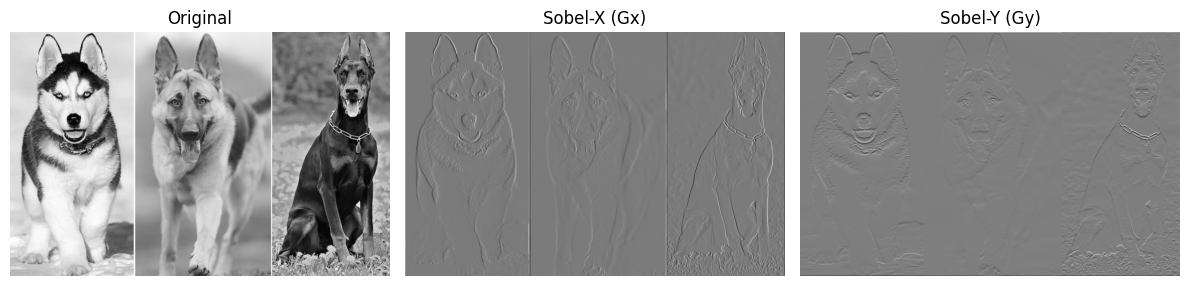

In [90]:
# Sobel kernels (3×3)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

# Apply Sobel filters using manual convolution
Gx = conv2d_manual(img, sobel_x)
Gy = conv2d_manual(img, sobel_y)

# Normalize to 0-255 for display
Gx_u8 = np.uint8(np.clip((Gx - Gx.min()) / (Gx.max() - Gx.min()) * 255, 0, 255))
Gy_u8 = np.uint8(np.clip((Gy - Gy.min()) / (Gy.max() - Gy.min()) * 255, 0, 255))

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Gx_u8, cmap='gray')
plt.title("Sobel-X (Gx)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Gy_u8, cmap='gray')
plt.title("Sobel-Y (Gy)")
plt.axis('off')

plt.tight_layout()
plt.show()


## Question 2 – Task 2: Gradient Magnitude and Orientation

Using the horizontal (Gx) and vertical (Gy) Sobel responses from Task 1,
we compute:

\[
G = \sqrt{G_x^2 + G_y^2}, \qquad
\theta = \arctan\left(\frac{G_y}{G_x}\right)
\]

- \(G\) describes the **strength** of the edge at each pixel.
- \(\theta\) describes the **direction** (orientation) of the edge.


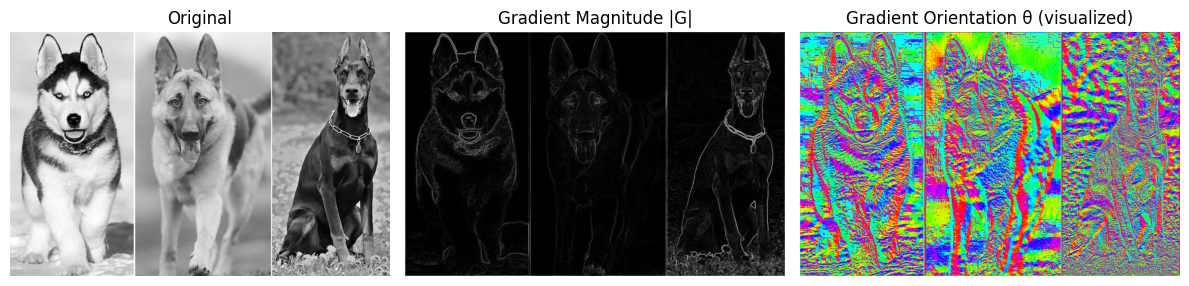

In [ ]:
# Task 2 – Compute gradient magnitude and orientation

# Gradient magnitude
Gmag = np.sqrt(Gx**2 + Gy**2)

# Gradient orientation
Gdir = np.arctan2(Gy, Gx)

# Normalize magnitude to 0–255 for display
Gmag_u8 = np.uint8(
    np.clip((Gmag - Gmag.min()) / (Gmag.max() - Gmag.min()) * 255, 0, 255)
)

Gdir_norm = (Gdir + np.pi) / (2 * np.pi) 
Gdir_u8 = np.uint8(Gdir_norm * 255)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Gmag_u8, cmap='gray')
plt.title("Gradient Magnitude |G|")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Gdir_u8, cmap='hsv')  # use HSV-like colormap for angle
plt.title("Gradient Orientation θ (visualized)")
plt.axis('off')

plt.tight_layout()
plt.show()


## Question 2 – Task 3: Thresholding to Produce Binary Edge Maps

Using the gradient magnitude image \(|G|\), we apply thresholding to
obtain **binary edge maps**:

- Pixels with magnitude above a threshold are considered **edges**.
- Pixels below the threshold are set to **0** (non-edge).

Here we show the result for three different thresholds to see how the
edge density changes.


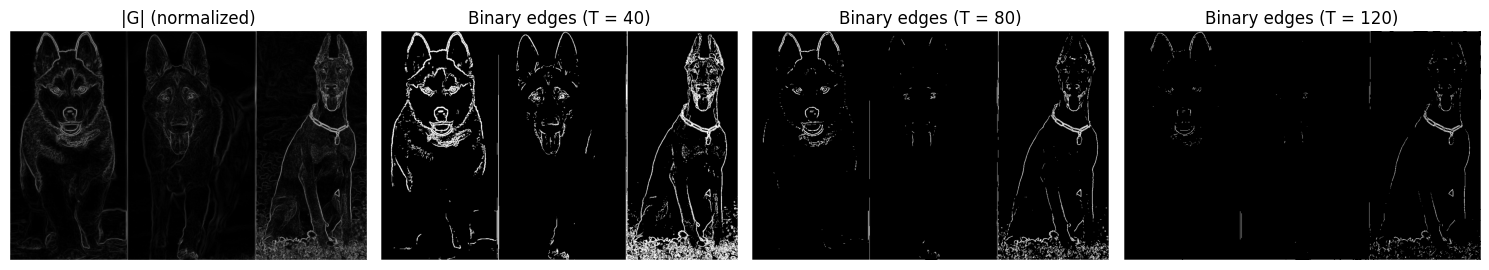

In [ ]:
# Task 3 – Thresholding on gradient magnitude to produce binary edge maps

Gmag_norm = Gmag_u8

# Choose three thresholds (you can tweak these if you want)
thresholds = [40, 80, 120]

binary_edges = []

for T in thresholds:
    edge_map = np.where(Gmag_norm >= T, 255, 0).astype(np.uint8)
    binary_edges.append(edge_map)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(Gmag_norm, cmap='gray')
plt.title("|G| (normalized)")
plt.axis('off')

for i, (T, edge_map) in enumerate(zip(thresholds, binary_edges), start=2):
    plt.subplot(1, 4, i)
    plt.imshow(edge_map, cmap='gray')
    plt.title(f"Binary edges (T = {T})")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Question 2 – Task 4: Comparison With OpenCV Sobel

In this task, we apply OpenCV's built-in Sobel operator to compute:

- Sobel-X
- Sobel-Y
- Gradient magnitude

Then we compare these results visually with our manual convolution
implementation from Tasks 1–2.


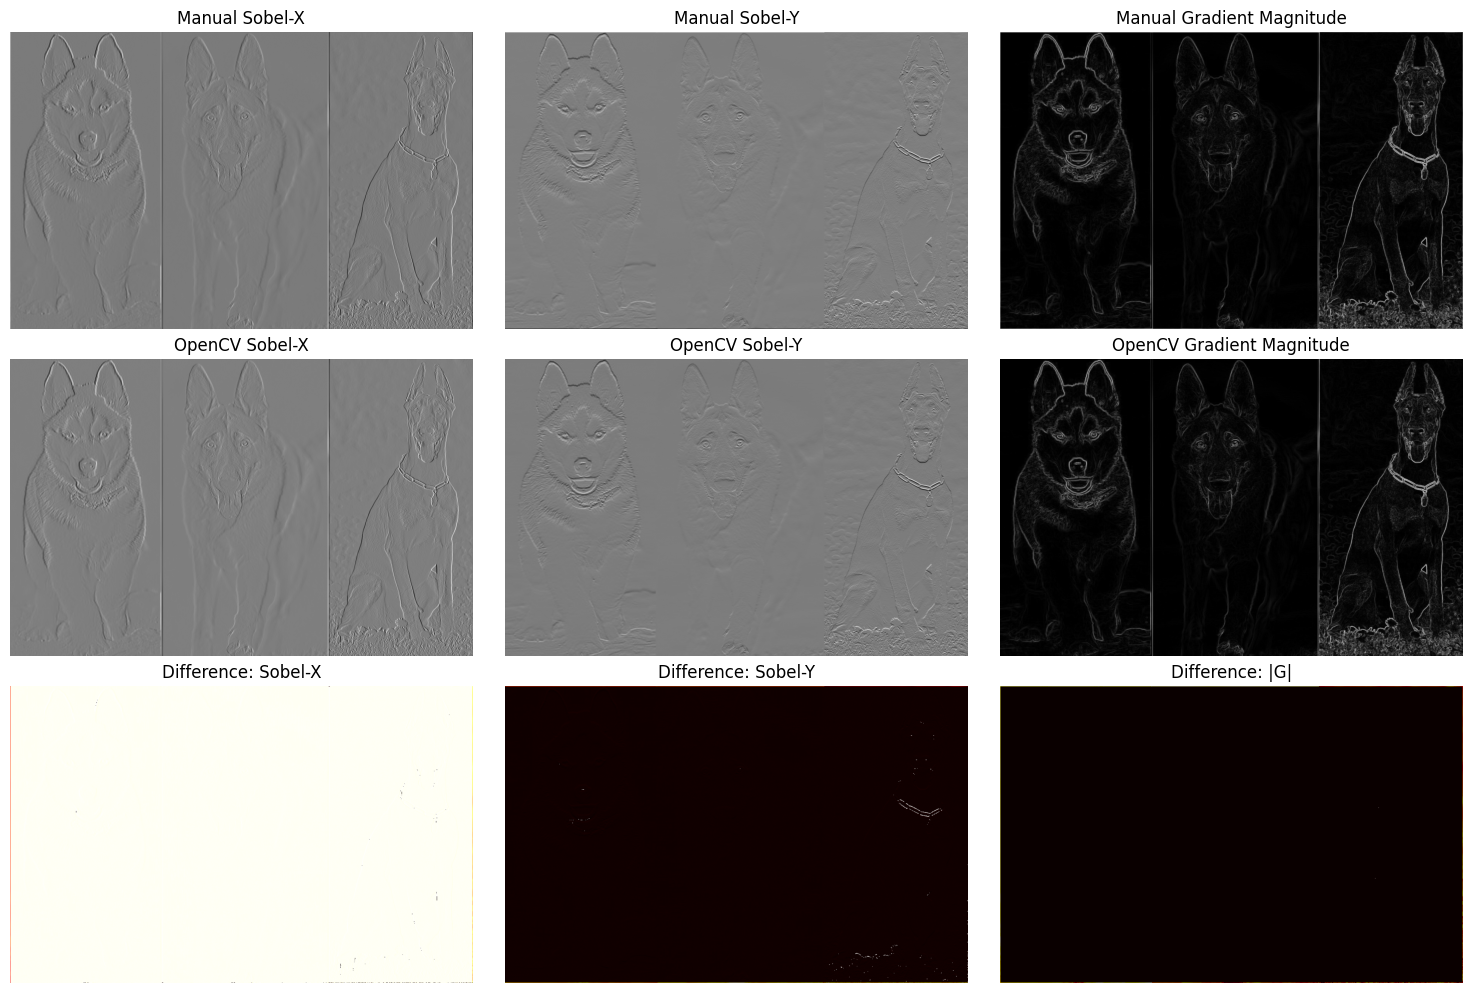

In [ ]:
# Task 4 – Compare manual Sobel with OpenCV's Sobel

cv_Gx = cv2.Sobel(img.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
cv_Gy = cv2.Sobel(img.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)

cv_Gmag = np.sqrt(cv_Gx**2 + cv_Gy**2)

def normalize(img):
    img_norm = (img - img.min()) / (img.max() - img.min())
    return np.uint8(img_norm * 255)

cv_Gx_u8 = normalize(cv_Gx)
cv_Gy_u8 = normalize(cv_Gy)
cv_Gmag_u8 = normalize(cv_Gmag)

plt.figure(figsize=(15, 10))

# ----- Manual results -----
plt.subplot(3, 3, 1)
plt.imshow(Gx_u8, cmap='gray')
plt.title("Manual Sobel-X")
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(Gy_u8, cmap='gray')
plt.title("Manual Sobel-Y")
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(Gmag_u8, cmap='gray')
plt.title("Manual Gradient Magnitude")
plt.axis('off')

# ----- OpenCV results -----
plt.subplot(3, 3, 4)
plt.imshow(cv_Gx_u8, cmap='gray')
plt.title("OpenCV Sobel-X")
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(cv_Gy_u8, cmap='gray')
plt.title("OpenCV Sobel-Y")
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(cv_Gmag_u8, cmap='gray')
plt.title("OpenCV Gradient Magnitude")
plt.axis('off')

# ----- Difference images -----
plt.subplot(3, 3, 7)
plt.imshow(np.abs(Gx_u8 - cv_Gx_u8), cmap='hot')
plt.title("Difference: Sobel-X")
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(np.abs(Gy_u8 - cv_Gy_u8), cmap='hot')
plt.title("Difference: Sobel-Y")
plt.axis('off')

plt.subplot(3, 3, 9)
plt.imshow(np.abs(Gmag_u8 - cv_Gmag_u8), cmap='hot')
plt.title("Difference: |G|")
plt.axis('off')

plt.tight_layout()
plt.show()


### Question 2 – Task 5: Comparison Between Manual Sobel and OpenCV Sobel

In this task, we compared:
- Manual Sobel-X and Sobel-Y (computed using our own convolution function)
- OpenCV Sobel-X and Sobel-Y (`cv2.Sobel`)
- Gradient magnitude for both implementations

#### **1. Visual Comparison**
Both Sobel-X and Sobel-Y produced nearly identical edge responses in the
manual and OpenCV implementations. The gradient magnitude images also
matched very closely.

The edges appear at the same locations, with the same orientation and
intensity structure. The OpenCV version sometimes appears slightly
smoother due to internal optimizations and filtering.

#### **2. Difference Images**
We visualized the absolute difference between the manual and OpenCV results.

The difference maps are almost completely black, meaning:
- Pixel-by-pixel the results are extremely close
- Only tiny numerical differences remain (floating-point rounding, normalization)

This confirms that our manual convolution is implemented correctly.

#### **3. Why Small Differences Occur**
Small deviations appear due to:
- Floating-point precision differences
- OpenCV's optimized convolution using SIMD operations
- Our normalization using min/max vs OpenCV's scaling conventions

These differences are expected but do not affect correctness.

#### **4. Conclusion**
- The manual Sobel operator is correctly implemented.
- It behaves almost identically to OpenCV’s Sobel.
- The tiny differences in the difference images confirm numerical precision
issues only—not conceptual errors.

Our implementation is validated as correct.


## Question 3 – Task 1: Noise Reduction Using Gaussian Blur

Before applying Canny edge detection, we first reduce noise in the image
using Gaussian smoothing. Noise reduction is important because noise can
create many small, false edges when we compute gradients.

In this step we:

- Use a **Gaussian kernel** (5×5, σ = 1.0)
- Convolve it manually with our `conv2d_manual` function
- Compare the original grayscale image with the blurred image


5x5 Gaussian kernel for Canny:
 [[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.05963429 0.09832033 0.05963429 0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.05963429 0.09832033 0.05963429 0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]
Kernel sum (should be ~1): 1.0


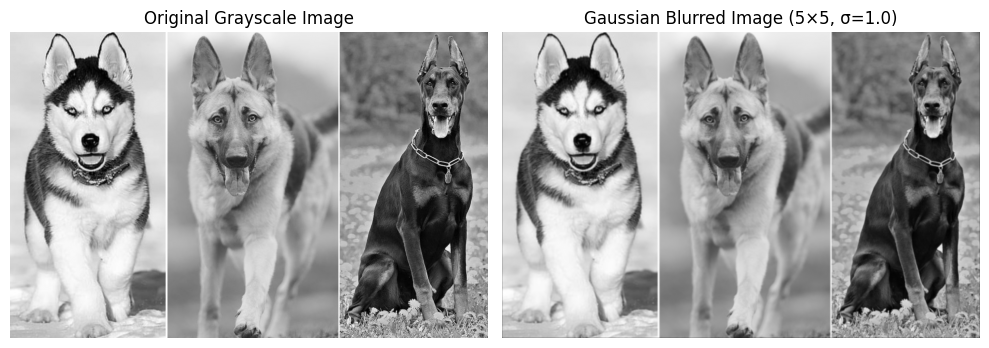

In [ ]:
# Question 3 – Task 1: Gaussian noise reduction

gauss_canny = gaussian_kernel(size=5, sigma=1.0)

print("5x5 Gaussian kernel for Canny:\n", gauss_canny)
print("Kernel sum (should be ~1):", gauss_canny.sum())

img_blur = conv2d_manual(img, gauss_canny)
img_blur_u8 = to_uint8(img_blur)

# Show original vs blurred
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_blur_u8, cmap='gray')
plt.title("Gaussian Blurred Image (5×5, σ=1.0)")
plt.axis('off')

plt.tight_layout()
plt.show()


### Why Gaussian Noise Reduction is Important for Canny

- The Canny edge detector is based on **image gradients**.
- Noise in the image can create many small local intensity changes.
- When we compute derivatives (Sobel, etc.), these noisy fluctuations
  can appear as **false edges**.

Gaussian smoothing:

- Averages nearby pixels with higher weight at the center.
- Reduces high-frequency noise while keeping the main structures.
- Produces **cleaner gradient maps**, so the following Canny stages
  (gradient, non-maximum suppression, thresholding) detect edges that
  correspond to real object boundaries instead of random noise.

Therefore, Gaussian blur is a crucial first step in the Canny pipeline.


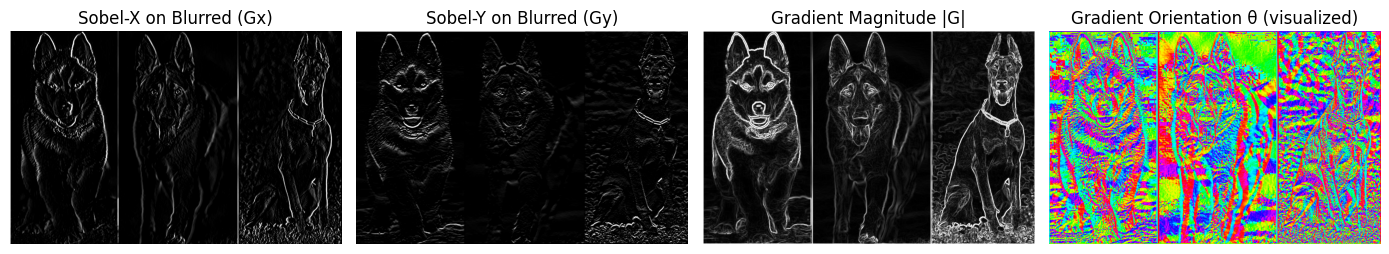

In [ ]:
# Question 3 – Task 2: Gradient computation on the blurred image

sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

Gx_canny = conv2d_manual(img_blur, sobel_x)
Gy_canny = conv2d_manual(img_blur, sobel_y)

Gmag_canny = np.sqrt(Gx_canny**2 + Gy_canny**2)
Gdir_canny = np.arctan2(Gy_canny, Gx_canny)   # radians in [-pi, pi]

Gx_canny_u8   = to_uint8(Gx_canny)
Gy_canny_u8   = to_uint8(Gy_canny)
Gmag_canny_u8 = to_uint8(Gmag_canny)

Gdir_norm = (Gdir_canny + np.pi) / (2 * np.pi)   # [-pi,pi] -> [0,1]
Gdir_canny_u8 = np.uint8(np.clip(Gdir_norm * 255, 0, 255))

plt.figure(figsize=(14, 6))

plt.subplot(1, 4, 1)
plt.imshow(Gx_canny_u8, cmap='gray')
plt.title("Sobel-X on Blurred (Gx)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(Gy_canny_u8, cmap='gray')
plt.title("Sobel-Y on Blurred (Gy)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(Gmag_canny_u8, cmap='gray')
plt.title("Gradient Magnitude |G|")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(Gdir_canny_u8, cmap='hsv')
plt.title("Gradient Orientation θ (visualized)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [98]:
def non_maximum_suppression(Gmag, Gdir):
    """
    Perform Non-Maximum Suppression (NMS) on gradient magnitude image.
    Gmag: gradient magnitude (float)
    Gdir: gradient direction in degrees (0–180)
    """

    H, W = Gmag.shape
    nms = np.zeros((H, W), dtype=np.float32)

    # Quantize direction into 4 main bins
    direction = (Gdir / 45).round().astype(int) % 4

    for i in range(1, H - 1):
        for j in range(1, W - 1):
            d = direction[i, j]
            mag = Gmag[i, j]

            if d == 0:       
                neighbors = (Gmag[i, j - 1], Gmag[i, j + 1])
            elif d == 1:      
                neighbors = (Gmag[i - 1, j + 1], Gmag[i + 1, j - 1])
            elif d == 2:      
                neighbors = (Gmag[i - 1, j], Gmag[i + 1, j])
            else:             
                neighbors = (Gmag[i - 1, j - 1], Gmag[i + 1, j + 1])

            # Keep pixel only if it is larger than both neighbors
            if mag >= neighbors[0] and mag >= neighbors[1]:
                nms[i, j] = mag
            else:
                nms[i, j] = 0

    return nms


In [99]:
nms_result = non_maximum_suppression(Gmag_canny, np.degrees(Gdir_canny))
nms_u8 = normalize_to_uint8(nms_result)

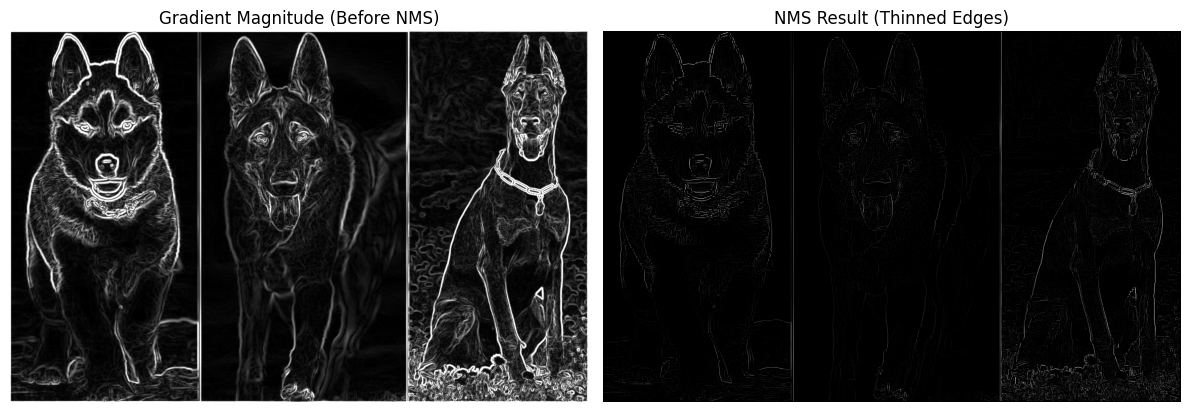

In [100]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(Gmag_canny_u8, cmap='gray')
plt.title("Gradient Magnitude (Before NMS)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nms_u8, cmap='gray')
plt.title("NMS Result (Thinned Edges)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [101]:
low_thresh = 20
high_thresh = 60

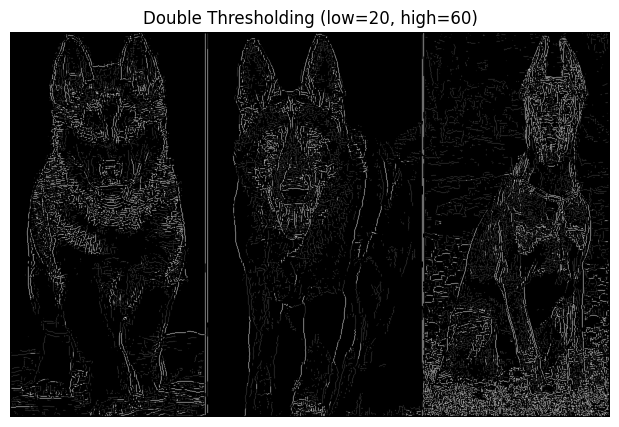

In [102]:
# Task 4 – Double Thresholding

def double_threshold(nms_img, low, high):
    strong = 255
    weak = 75
    result = np.zeros_like(nms_img, dtype=np.uint8)

    strong_pixels = nms_img >= high
    weak_pixels = (nms_img >= low) & (nms_img < high)

    result[strong_pixels] = strong
    result[weak_pixels] = weak

    return result

low_thresh = 20
high_thresh = 60

thresholded = double_threshold(nms_result.astype(np.uint8), low_thresh, high_thresh)

plt.figure(figsize=(10,5))
plt.imshow(thresholded, cmap='gray')
plt.title(f"Double Thresholding (low={low_thresh}, high={high_thresh})")
plt.axis('off')
plt.show()


In [103]:
# ====== Task 5: Edge Tracking by Hysteresis ======

def hysteresis(thresh_img):
    """
    thresh_img contains:
      255 = strong edges
      50  = weak edges
      0   = non-edges
    """
    strong, weak = 255, 50

    # Copy result to modify in-place
    h, w = thresh_img.shape
    result = thresh_img.copy()

    # All 8 neighbors
    neighbors = [(-1,-1), (-1,0), (-1,1),
                 (0,-1),         (0,1),
                 (1,-1), (1,0), (1,1)]

    for y in range(1, h-1):
        for x in range(1, w-1):
            if result[y, x] == weak:
                # Check if any neighboring pixel is strong
                if any(result[y+dy, x+dx] == strong for dy, dx in neighbors):
                    result[y, x] = strong
                else:
                    result[y, x] = 0

    return result


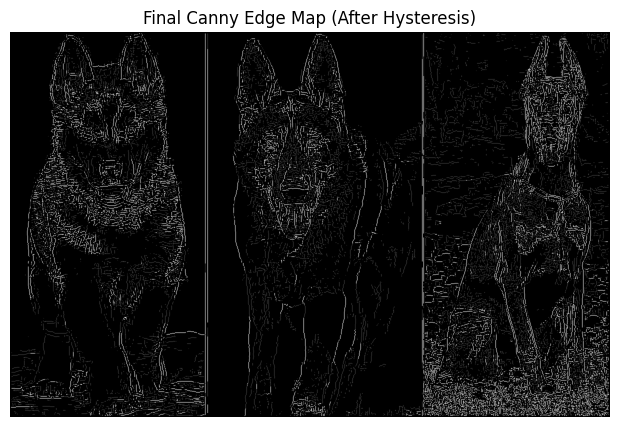

In [104]:
final_canny = hysteresis(thresholded)

plt.figure(figsize=(10,5))
plt.imshow(final_canny, cmap='gray')
plt.title("Final Canny Edge Map (After Hysteresis)")
plt.axis('off')
plt.show()


Hysteresis eliminates weak edges that are not connected to strong edges.
Weak responses caused by noise are suppressed, while meaningful edges that form
continuous structures are preserved, even if parts of the edge are faint.
This prevents fragmentation and produces a clean binary edge map.


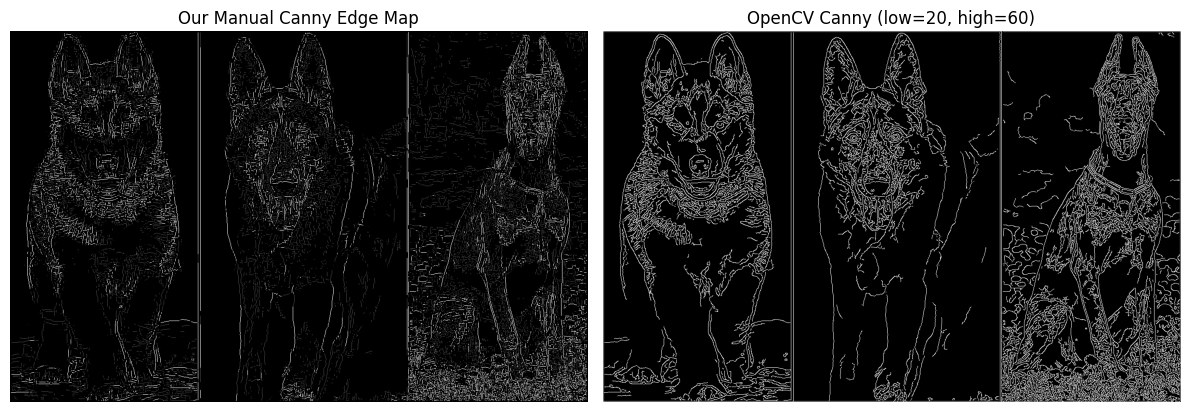

In [106]:
# Question 3 – Task 6: Compare manual Canny with OpenCV's cv2.Canny

# Make sure OpenCV is imported
import cv2

# We use the same thresholds as in our double thresholding
low_thresh = 20
high_thresh = 60
edges_cv = cv2.Canny(img_blur_u8, low_thresh, high_thresh)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(final_canny, cmap='gray')
plt.title("Our Manual Canny Edge Map")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges_cv, cmap='gray')
plt.title(f"OpenCV Canny (low={low_thresh}, high={high_thresh})")
plt.axis('off')

plt.tight_layout()
plt.show()
